## Experiment CNN models
Use this to test different CNN models, augmentations, and hyperparameters.

In [2]:
import tensorflow as tf
import keras
import keras_cv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


import os

2024-04-29 16:15:31.570059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 16:15:34.191462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Import our data

DATADIR = "../garbage_classification_enhanced"
BATCH_SIZE = 32

garbage_types = os.listdir(DATADIR)

# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(DATADIR, garbage_type)):
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(DATADIR, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])
# Display the first few entries of the DataFrame
df.head()


,filepath,label
0,../garbage_classification_enhanced/green-glass...,green-glass
1,../garbage_classification_enhanced/green-glass...,green-glass
2,../garbage_classification_enhanced/green-glass...,green-glass
3,../garbage_classification_enhanced/green-glass...,green-glass
4,../garbage_classification_enhanced/green-glass...,green-glass


Train size = 11426
Validation size = 2857
Test size = 1587
Average class probability in training set:   0.08333333333333333
Average class probability in validation set: 0.08333333333333333
Average class probability in test set:       0.08333333333333333


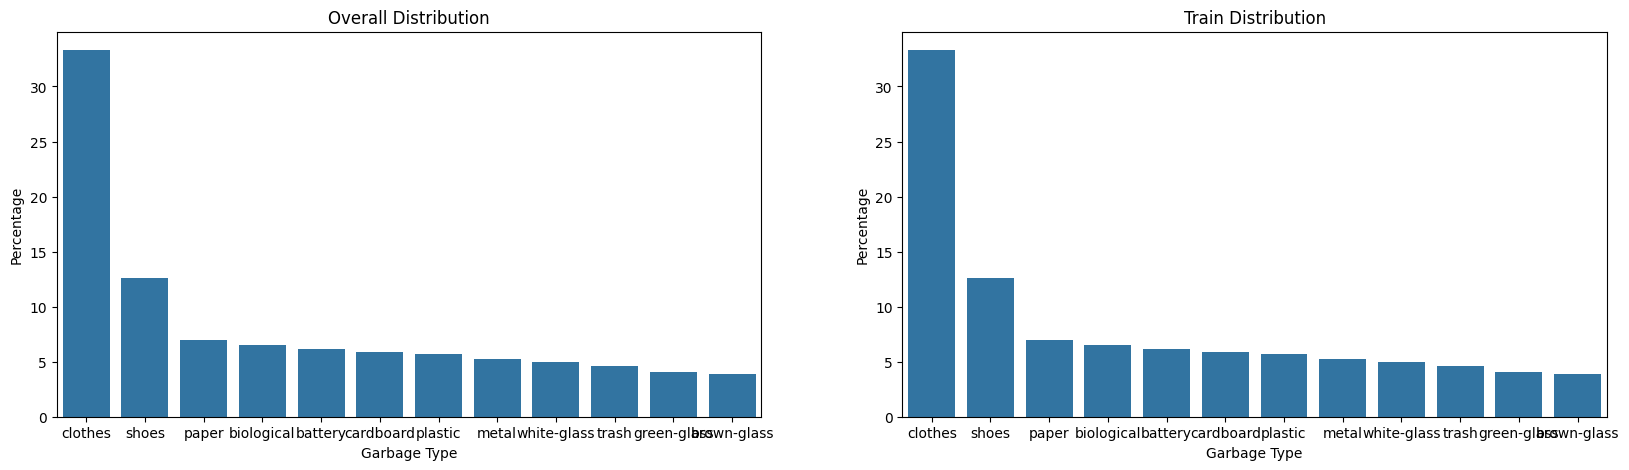

In [4]:
# Split with stratification
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

print(f"Train size = {len(train_df)}")
print(f"Validation size = {len(val_df)}")
print(f"Test size = {len(test_df)}")

# Check the distribution of the labels in the datasets
print(f"Average class probability in training set:   {train_df['label'].value_counts(normalize=True).mean()}")
print(f"Average class probability in validation set: {val_df['label'].value_counts(normalize=True).mean()}")
print(f"Average class probability in test set:       {test_df['label'].value_counts(normalize=True).mean()}")

# Distributions
overall_distribution = df['label'].value_counts(normalize=True) * 100
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x=overall_distribution.index, y=overall_distribution, ax=ax[0])
ax[0].set_title('Overall Distribution')
ax[0].set_xlabel('Garbage Type')
ax[0].set_ylabel('Percentage')

sns.barplot(x=train_distribution.index, y=train_distribution, ax=ax[1])
ax[1].set_title('Train Distribution')
ax[1].set_xlabel('Garbage Type')
ax[1].set_ylabel('Percentage')

plt.show()

In [6]:
# Look at the class weights
class_labels = df['label'].unique()
label_to_index = {label: idx for idx, label in enumerate(df['label'].unique())}
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=df['label'])

class_weights = dict(zip(label_to_index.values(), weights))
class_weights

{0: 2.063182527301092,
 1: 1.2777777777777777,
 2: 1.350868232890705,
 3: 2.1365105008077543,
 4: 0.659272183449651,
 5: 1.193592057761733,
 6: 1.580047789725209,
 7: 1.467813540510544,
 8: 1.4129273504273505,
 9: 1.6614321608040201,
 10: 0.2501891789632993,
 11: 1.8216253443526171}

In [7]:
# Load the data
NUM_CLASSES = len(df['label'].unique())

def load_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels= 3)
  image = tf.image.resize(image, (256, 256))
  image = tf.cast(image, tf.float32) / 255.0
  return image

# Convert labels to indices using TensorFlow
unique_labels = tf.constant(df['label'].unique())
labels_indices = tf.range(tf.size(unique_labels), dtype=tf.int32)

# Create TensorFlow lookup table
table_init = tf.lookup.KeyValueTensorInitializer(keys=unique_labels, values=labels_indices, key_dtype=tf.string, value_dtype=tf.int32)
table = tf.lookup.StaticHashTable(table_init, default_value=-1)


def create_dataset(file_names, labels):
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
  dataset = dataset.map(lambda file_name, label: (load_image(file_name), tf.one_hot(table.lookup(label), depth=NUM_CLASSES)))
  return dataset

train_ds = create_dataset(train_df['filepath'].values, train_df['label'].values)
val_ds = create_dataset(val_df['filepath'].values, val_df['label'].values)
test_ds = create_dataset(test_df['filepath'].values, test_df['label'].values)

def package_inputs(image, label):
    return {"images": image, "labels": label}

train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

2024-04-29 16:16:14.634601: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 16:16:14.641926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 16:16:14.641992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 16:16:14.645478: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 16:16:14.645585: I external/local_xla/xla/stream_executor

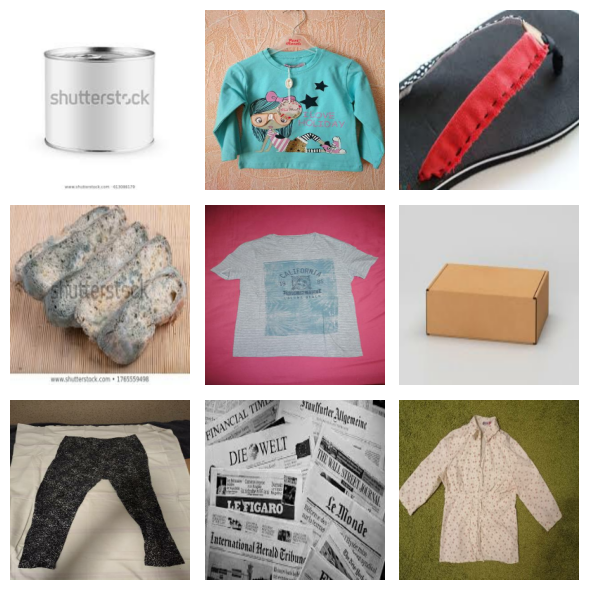

In [8]:
# Let's take a look at the data
batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]
label_batch = batch["labels"]

keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 1),
    show=True,
)

### Augmentations
- RandomFlip (horizontal and vertical)
- RandomCropAndResize
- Normalize pixel values to [0, 1]

The other augmentations are more experimental and can be skipped or added to test their effect.

In [9]:
# Randomly flip the image horizontally and vertically
import keras_cv.layers.preprocessing


random_flip = keras_cv.layers.RandomFlip(mode="horizontal_and_vertical")

# Randomly crop and resize the image
crop_and_resize = keras_cv.layers.RandomCropAndResize(
    target_size=(224, 224),
    crop_area_factor=(0.8, 1.0),
    aspect_ratio_factor=(0.9, 1.1)
)

# Apply some random augmentations
rand_augment = keras_cv.layers.RandAugment(
    augmentations_per_image=3,
    value_range=(0, 1),
    magnitude=0.5,
    magnitude_stddev=0.2,
    rate=1.0
)

# Cut parts of the image and paste them on other images
cut_mix = keras_cv.layers.preprocessing.CutMix()

# Mix two images together
mix_up = keras_cv.layers.preprocessing.MixUp()

# Randomly choose between CutMix and MixUp
cut_mix_or_mix_up = keras_cv.layers.RandomChoice([cut_mix, mix_up], batchwise=True)

# Define the augmentation function
def augmenter_train(inputs):
    #images = tf.cast(images, tf.float32) / 255.0
    inputs = random_flip(inputs, training=True)
    inputs = crop_and_resize(inputs, training=True)
    inputs = rand_augment(inputs, training=True)
    inputs = cut_mix_or_mix_up(inputs)
    
    return inputs

def augmenter_val(images, labels):
    images = tf.cast(images, tf.float32) / 255.0

    return images, labels

In [10]:
train_ds = train_ds.map(augmenter_train, num_parallel_calls=tf.data.AUTOTUNE)

#val_ds = val_ds.map(augmenter_val, num_parallel_calls=tf.data.AUTOTUNE)

#test_ds = test_ds.map(augmenter_val, num_parallel_calls=tf.data.AUTOTUNE)



2024-04-29 16:16:31.347803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node rand_augment_1/map/while/LoopExecuted/_412/_83}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-04-29 16:16:31.347894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node rand_augment_1/map/while/LoopExecuted/_412/_83}}]]
	 [[rand_augment_1/map/while/body/_375/rand_augment_1/map/while/cond_1/else/_741/rand_augment_1/map/while/cond_1/random_choice_1/switch_case/indexed_case/branch6/_839/rand_augment_1/map/while/cond_1/random_choice_1/switch_case/indexed_case/random_shear_1/stateful_uniform_1/RngReadAndSkip/_218]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-04-29 16:16:31.347916: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10771952508603104963
2024-04-29 16:

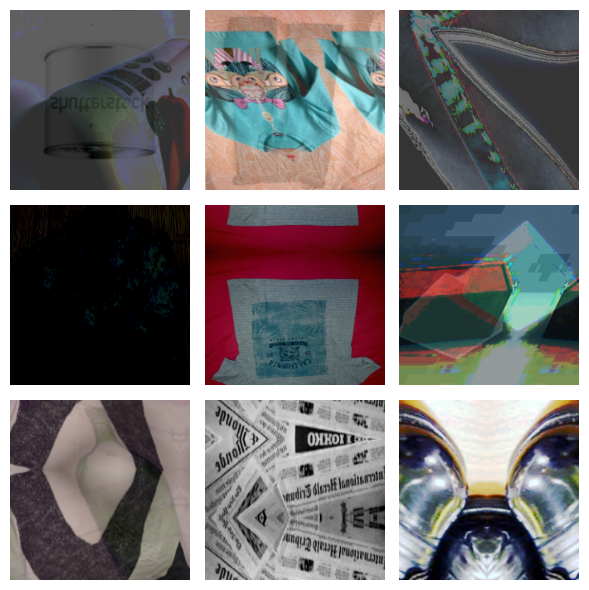

In [11]:
image_batch = next(iter(train_ds.take(1)))['images']

keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 1),
    show=True,
)

In [12]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]

train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
backbone = keras_cv.models.EfficientNetV2B0Backbone()
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(12, activation="softmax"),
    ]
)

loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    loss=loss,
    optimizer='Adam',
    metrics=[
        keras.metrics.CategoricalAccuracy(),
        keras.metrics.TopKCategoricalAccuracy(k=5),
    ],
)

In [14]:
# Set up callbacks
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
import datetime

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Callbacks definition
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1),
]

In [50]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100


I0000 00:00:1714399548.659580    8234 service.cc:145] XLA service 0x7ff9080116f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714399548.661624    8234 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-04-29 16:05:55.491527: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 16:06:09.427751: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-04-29 16:06:57.735076: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng1{k2=4,k3=0} for conv (f32[32,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,225,225]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation

134/358 ━━━━━━━━━━━━━━━━━━━━ 1:16 341ms/step - categorical_accuracy: 0.2153 - loss: 4.0898 - top_k_categorical_accuracy: 0.5820

2024-04-29 16:09:40.176703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


315/358 ━━━━━━━━━━━━━━━━━━━━ 15s 355ms/step - categorical_accuracy: 0.2545 - loss: 3.6386 - top_k_categorical_accuracy: 0.6006

2024-04-29 16:10:46.330379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - categorical_accuracy: 0.2605 - loss: 3.5737 - top_k_categorical_accuracy: 0.6033

2024-04-29 16:12:44.837446: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
/home/magsam/miniconda3/envs/tumor-segmentation/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


358/358 ━━━━━━━━━━━━━━━━━━━━ 489s 677ms/step - categorical_accuracy: 0.2606 - loss: 3.5723 - top_k_categorical_accuracy: 0.6033 - val_categorical_accuracy: 0.3336 - val_loss: 2.6923 - val_top_k_categorical_accuracy: 0.6825 - learning_rate: 0.0010
Epoch 2/100
 16/358 ━━━━━━━━━━━━━━━━━━━━ 2:44 482ms/step - categorical_accuracy: 0.3541 - loss: 2.7159 - top_k_categorical_accuracy: 0.6376

: 

In [ ]:
# Test model

def test_model(model, test_ds, labels):
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

    # Get the true labels and predicted labels
    y_true = []
    y_pred = []

    for image_batch, label_batch in test_ds:
        y_true.extend(label_batch.numpy())
        y_pred.extend(model.predict(image_batch).argmax(axis=1))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.show()

    # Display the classification report
    print(classification_report(y_true, y_pred, target_names=labels))
